<a href="https://colab.research.google.com/github/GunayRustamova/-InternIntelligence_NLU/blob/main/NLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTALLATION AND SETUP**

In [4]:
!pip install -q transformers datasets accelerate wandb seqeval torch scikit-learn

import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from transformers.trainer_callback import EarlyStoppingCallback
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
import wandb
from typing import Dict, List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

print("All packages imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

All packages imported successfully
PyTorch version: 2.9.0+cu126
Using device: cuda


**WEIGHTS & BIASES INITIALIZATION**

In [6]:
wandb.login()

wandb.init(
    project="ner-bert-finetuning",
    name="bert-base-wikiann",
    config={
        "model_name": "bert-base-cased",
        "dataset": "wikiann-en",
        "task": "named_entity_recognition",
        "epochs": 3,
        "batch_size": 16,
        "learning_rate": 2e-5,
    }
)

print("Weights & Biases initialized")

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gunayrustamova (gunayrustamova-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Weights & Biases initialized


**DATA LOADING AND EXPLORATION**


Loading WikiANN dataset...


README.md: 0.00B [00:00, ?B/s]

en/validation-00000-of-00001.parquet:   0%|          | 0.00/748k [00:00<?, ?B/s]

en/test-00000-of-00001.parquet:   0%|          | 0.00/748k [00:00<?, ?B/s]

en/train-00000-of-00001.parquet:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]


Dataset structure:
DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

Sample from training set:
{'tokens': ['R.H.', 'Saunders', '(', 'St.', 'Lawrence', 'River', ')', '(', '968', 'MW', ')'], 'ner_tags': [3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0], 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'], 'spans': ['ORG: R.H. Saunders', 'ORG: St. Lawrence River']}

Dataset Statistics:
Training samples: 20000
Validation samples: 10000
Test samples: 10000

NER Labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

Label mapping:
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}


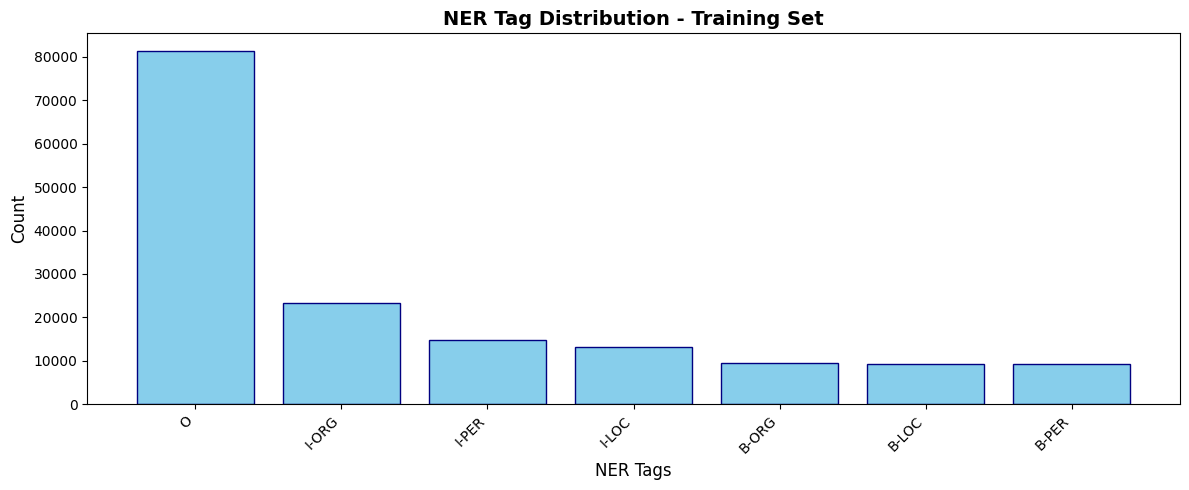

<Figure size 640x480 with 0 Axes>

In [7]:
print("\nLoading WikiANN dataset...")

dataset = load_dataset("wikiann", "en")

print("\nDataset structure:")
print(dataset)
print("\nSample from training set:")
print(dataset['train'][0])

print("\nDataset Statistics:")
print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

label_list = dataset['train'].features['ner_tags'].feature.names
print(f"\nNER Labels: {label_list}")

id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}

print(f"\nLabel mapping:\n{id2label}")

def plot_label_distribution(dataset_split, split_name):
    all_tags = []
    for example in dataset_split:
        all_tags.extend(example['ner_tags'])

    tag_counts = pd.Series(all_tags).value_counts()
    tag_names = [id2label[i] for i in tag_counts.index]

    plt.figure(figsize=(12, 5))
    plt.bar(tag_names, tag_counts.values, color='skyblue', edgecolor='navy')
    plt.xlabel('NER Tags', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'NER Tag Distribution - {split_name} Set', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    wandb.log({f"{split_name}_label_distribution": wandb.Image(plt)})

plot_label_distribution(dataset['train'], 'Training')

**DATA PREPROCESSING AND TOKENIZATION**

In [8]:
MODEL_NAME = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"\nTokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding=False,
        max_length=512
    )

    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print("\nTokenizing datasets...")
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset['train'].column_names,
    desc="Tokenizing"
)

print("Tokenization complete")
print(f"\nTokenized training sample:")
print(f"Input IDs length: {len(tokenized_datasets['train'][0]['input_ids'])}")
print(f"Labels length: {len(tokenized_datasets['train'][0]['labels'])}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]


Tokenizer loaded: bert-base-cased
Vocabulary size: 28996

Tokenizing datasets...


Tokenizing:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/20000 [00:00<?, ? examples/s]

Tokenization complete

Tokenized training sample:
Input IDs length: 18
Labels length: 18


**MODEL INITIALIZATION**

In [9]:
num_labels = len(label_list)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"\nModel initialized: {MODEL_NAME}")
print(f"Number of parameters: {model.num_parameters():,}")
print(f"Number of labels: {num_labels}")
print(f"Device: {device}")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model initialized: bert-base-cased
Number of parameters: 107,725,063
Number of labels: 7
Device: cuda


**EVALUATION METRICS**

In [10]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    precision = precision_score(true_labels, true_predictions)
    recall = recall_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True
)


**TRAINING CONFIGURATION**

In [11]:
training_args = TrainingArguments(
    output_dir="./ner-bert-model",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=100,
    report_to="wandb",
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    seed=42,
    save_total_limit=2,
)

print("\nTraining Configuration:")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Mixed precision: {training_args.fp16}")


Training Configuration:
Epochs: 3
Batch size: 16
Learning rate: 2e-05
Mixed precision: True


**TRAINER INITIALIZATION AND TRAINING**

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\nStarting training...")
print("=" * 70)

train_result = trainer.train()

print("\nTraining completed")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training loss: {train_result.metrics['train_loss']:.4f}")



Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.296300,0.243667,0.782170,0.822423,0.801792,0.923984
2,0.202900,0.229671,0.818750,0.843348,0.830867,0.931621
3,0.141300,0.246446,0.822029,0.847307,0.834476,0.933086



Training completed
Training time: 397.03 seconds
Training loss: 0.2816


**EVALUATION ON TEST SET**

In [13]:
print("\nEvaluating on test set...")

test_results = trainer.evaluate(tokenized_datasets["test"])

print("\nTest Set Results:")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall: {test_results['eval_recall']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")

wandb.log({
    "test_precision": test_results['eval_precision'],
    "test_recall": test_results['eval_recall'],
    "test_f1": test_results['eval_f1'],
    "test_accuracy": test_results['eval_accuracy']
})

predictions = trainer.predict(tokenized_datasets["test"])
pred_logits = predictions.predictions
pred_labels = np.argmax(pred_logits, axis=2)


Evaluating on test set...



Test Set Results:
Precision: 0.8247
Recall: 0.8512
F1 Score: 0.8377
Accuracy: 0.9350


**DETAILED ANALYSIS AND VISUALIZATION**


Per-Entity Type Performance:

PER:
  Precision: 0.8814
  Recall: 0.9148
  F1-Score: 0.8978
  Support: 4556

ORG:
  Precision: 0.7535
  Recall: 0.7699
  F1-Score: 0.7616
  Support: 4745

LOC:
  Precision: 0.8406
  Recall: 0.8718
  F1-Score: 0.8559
  Support: 4657


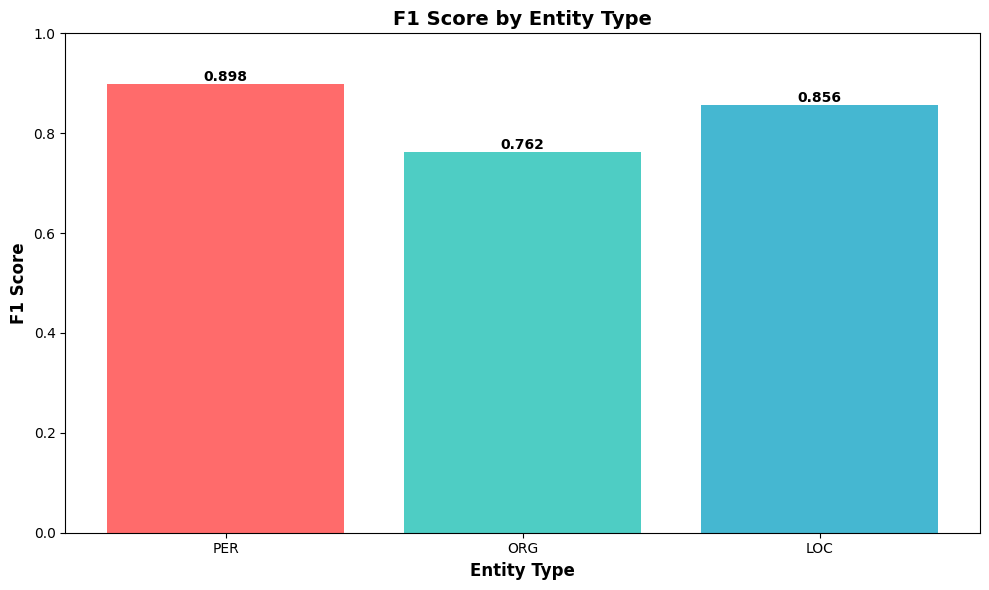

<Figure size 640x480 with 0 Axes>

In [14]:
def get_entity_level_metrics(predictions, labels):
    pred_labels_flat = np.argmax(predictions.predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_labels_flat, predictions.label_ids)
    ]

    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_labels_flat, predictions.label_ids)
    ]

    report = classification_report(true_labels, true_predictions, output_dict=True)

    return report

detailed_results = get_entity_level_metrics(predictions, predictions.label_ids)

print("\nPer-Entity Type Performance:")
print("=" * 70)

entity_types = ['PER', 'ORG', 'LOC']
for entity in entity_types:
    if entity in detailed_results:
        metrics = detailed_results[entity]
        print(f"\n{entity}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-Score: {metrics['f1-score']:.4f}")
        print(f"  Support: {metrics['support']}")

f1_scores = [detailed_results.get(et, {}).get('f1-score', 0) for et in entity_types]

plt.figure(figsize=(10, 6))
bars = plt.bar(entity_types, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.xlabel('Entity Type', fontsize=12, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12, fontweight='bold')
plt.title('F1 Score by Entity Type', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

wandb.log({"entity_f1_scores": wandb.Image(plt)})

**INFERENCE PIPELINE**

In [15]:
def predict_entities(text: str, model, tokenizer):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        return_offsets_mapping=True
    )

    offset_mapping = inputs.pop("offset_mapping")[0]
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)

    predicted_labels = [id2label[p.item()] for p in predictions[0]]

    entities = []
    current_entity = None
    entity_start = None
    entity_end = None

    for idx, (label, (start, end)) in enumerate(zip(predicted_labels, offset_mapping)):
        if start == 0 and end == 0:
            if current_entity is not None:
                entity_text = text[entity_start:entity_end].strip()
                entities.append((entity_text, current_entity))
                current_entity = None
            continue

        if label.startswith("B-"):
            if current_entity is not None:
                entity_text = text[entity_start:entity_end].strip()
                entities.append((entity_text, current_entity))

            current_entity = label[2:]
            entity_start = start
            entity_end = end

        elif label.startswith("I-") and current_entity == label[2:]:
            entity_end = end

        else:
            if current_entity is not None:
                entity_text = text[entity_start:entity_end].strip()
                entities.append((entity_text, current_entity))
                current_entity = None

    if current_entity is not None:
        entity_text = text[entity_start:entity_end].strip()
        entities.append((entity_text, current_entity))

    return entities

print("\nTesting Inference Pipeline:")
print("=" * 70)

test_sentences = [
    "Apple Inc. was founded by Steve Jobs in Cupertino, California.",
    "The United Nations held a meeting in New York last Tuesday.",
    "Elon Musk announced that Tesla and SpaceX are working on new projects.",
    "The research was conducted at Stanford University in collaboration with MIT."
]

for sentence in test_sentences:
    print(f"\nText: {sentence}")
    entities = predict_entities(sentence, model, tokenizer)
    print("Entities found:")
    for text, entity_type in entities:
        print(f"   - {text} [{entity_type}]")


Testing Inference Pipeline:

Text: Apple Inc. was founded by Steve Jobs in Cupertino, California.
Entities found:
   - Apple Inc. [ORG]
   - Steve Jobs [PER]
   - Cupertino, California [LOC]

Text: The United Nations held a meeting in New York last Tuesday.
Entities found:
   - United Nations [ORG]
   - New York [LOC]

Text: Elon Musk announced that Tesla and SpaceX are working on new projects.
Entities found:
   - Elon Musk [PER]
   - Tesla [ORG]
   - SpaceX [ORG]

Text: The research was conducted at Stanford University in collaboration with MIT.
Entities found:
   - Stanford University [ORG]
   - MIT [ORG]


**SAVE MODEL**

In [16]:
model.save_pretrained("./ner-bert-final")
tokenizer.save_pretrained("./ner-bert-final")

print("\nModel saved to './ner-bert-final'")

def ner_inference_demo():
    print("\n" + "=" * 70)
    print("Named Entity Recognition Demo")
    print("=" * 70)
    print("\nEnter text to analyze or 'quit' to exit:\n")

    while True:
        text = input("Your text: ").strip()

        if text.lower() in ['quit', 'exit', 'q']:
            print("\nGoodbye!")
            break

        if not text:
            continue

        entities = predict_entities(text, model, tokenizer)

        if entities:
            print("\nEntities found:")
            for entity_text, entity_type in entities:
                print(f"   - {entity_text} [{entity_type}]")
        else:
            print("\nNo entities found.")
        print()


Model saved to './ner-bert-final'


**EXPORT RESULTS AND FINALIZE**

In [17]:
summary = {
    "Model": MODEL_NAME,
    "Dataset": "WikiANN-EN",
    "Training Samples": len(dataset['train']),
    "Test Samples": len(dataset['test']),
    "F1 Score": test_results['eval_f1'],
    "Precision": test_results['eval_precision'],
    "Recall": test_results['eval_recall'],
    "Accuracy": test_results['eval_accuracy'],
    "Training Time (s)": train_result.metrics['train_runtime'],
}

summary_df = pd.DataFrame([summary])
print("\nFinal Summary:")
print(summary_df.to_string(index=False))

summary_df.to_csv("ner_training_summary.csv", index=False)
print("\nSummary saved to 'ner_training_summary.csv'")

wandb.finish()

print("\n" + "=" * 70)
print("NER Pipeline Complete")
print("=" * 70)
print("\nDeliverables:")
print("   - Fine-tuned model: ./ner-bert-final/")
print("   - Training logs: ./logs/")
print("   - Summary report: ner_training_summary.csv")
print("   - W&B dashboard: Check your wandb project")
print("\nNext steps:")
print("   - Review metrics on Weights & Biases dashboard")
print("   - Test the model with your own text")
print("   - Deploy the model using the inference function")
print("   - Fine-tune hyperparameters for better performance")
print("=" * 70)


Final Summary:
          Model    Dataset  Training Samples  Test Samples  F1 Score  Precision   Recall  Accuracy  Training Time (s)
bert-base-cased WikiANN-EN             20000         10000  0.837723   0.824669 0.851196  0.935027           397.0251

Summary saved to 'ner_training_summary.csv'


eval/accuracy,▁▆▇█
eval/f1,▁▇▇█
eval/loss,▇▁█▆
eval/precision,▁▇██
eval/recall,▁▆▇█
eval/runtime,█▁▂▄
eval/samples_per_second,▁█▇▄
eval/steps_per_second,▁█▇▄
test/accuracy,▁
test/f1,▁
+15,...



NER Pipeline Complete

Deliverables:
   - Fine-tuned model: ./ner-bert-final/
   - Training logs: ./logs/
   - Summary report: ner_training_summary.csv
   - W&B dashboard: Check your wandb project

Next steps:
   - Review metrics on Weights & Biases dashboard
   - Test the model with your own text
   - Deploy the model using the inference function
   - Fine-tune hyperparameters for better performance
